# Рекомендация тарифов

В моем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — она уже сделана.

**Примечание:** Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Откроем и изучим файл

In [1]:
import pandas as pd
from sklearn.metrics import accuracy_score # проверяет качество
from sklearn.tree import DecisionTreeRegressor # модель дерево решений, это можно было удалить 
from sklearn.ensemble import RandomForestClassifier # модель лес
from sklearn.linear_model import LinearRegression # 
from sklearn.model_selection import train_test_split # разбивает на выборки
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier # модель дерево решений
from matplotlib import pyplot as plt # для графиков
import seaborn as sns # для графиков



import warnings
warnings.filterwarnings("ignore")

In [2]:
try:
    df = pd.read_csv('/datasets/users_behavior.csv')
except:
    df = pd.read_csv('users_behavior.csv')

## Описание данных
Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. 

Известно:
-	сalls — количество звонков,
-	minutes — суммарная длительность звонков в минутах,
-	messages — количество sms-сообщений,
-	mb_used — израсходованный интернет-трафик в Мб,
-	is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).


In [3]:
display(df)
df.info()


,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
...,...,...,...,...,...
3209,122.0,910.98,20.0,35124.90,1
3210,25.0,190.36,0.0,3275.61,0
3211,97.0,634.44,70.0,13974.06,0
3212,64.0,462.32,90.0,31239.78,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [4]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


**Итог:**
Данные готовы к использованию. Пропусков не наблюдается.

## Разбейте данные на выборки

***Спрятанной тестовой выборки нет. Значит, данные нужно разбить на три части: обучающую, валидационную и тестовую. Размеры тестового и валидационного наборов должны быть равны. Исходные данные разобьем в соотношении 3:1:1. (60% : 20% : 20%)***

In [5]:
#df.loc[df['is_ultra'] == 1, 'is_ultra']= "Ультра"
#df.loc[df['is_ultra'] == 0, 'is_ultra']= "Смарт"


In [6]:
features = df.loc[:,'minutes':'mb_used'] # Отберем НЕ ЦЕЛЕВЫЕ признаки
target = df['is_ultra'] # ЦЕЛЕВОЙ ПРИЗНАК
target.value_counts()

           


0    2229
1     985
Name: is_ultra, dtype: int64

- создаем тренировочную выборку с 60% и 40% пока отвоодим на тестовую;

In [7]:
features_train,features_test, target_train, target_test = train_test_split(\
                        features, target, test_size=0.40, stratify = target , random_state=12345) 
print(features.shape)
print(target.shape)
print(features_train.shape)  # 60%
print(target_train.shape)    # 60%
print(features_test.shape)   # 40%
print(target_test.shape)     # 40%

(3214, 3)
(3214,)
(1928, 3)
(1928,)
(1286, 3)
(1286,)


### Благодаря stratify = target , сохраняет пропорцию, ниже факт, он сохранил пропорцию 0 и 1
•	Обрати внимание на аргумент stratify, он позволит сохранить изначальное распределение таргетов во всех новых датасетах. 
То есть имеется ввиду, что если изначальное распределение было 60 на 40, даже в малой выборке он это распределение сохранить – это нужно проверить


In [8]:
target_test.value_counts() 

0    892
1    394
Name: is_ultra, dtype: int64

In [9]:
target_train.value_counts()

0    1337
1     591
Name: is_ultra, dtype: int64

- делим тестовую выборку на 2 части , итого из 40% получаем 2 по 20%;

In [10]:
features_valid, features_test, target_valid, target_test  = train_test_split(\
                        features_test, target_test, test_size=0.50, random_state=12345) 

print(features.shape)
print(target.shape)
print(features_train.shape)   # 60%
print(target_train.shape)     # 60%
print(features_test.shape)    # 20%
print(target_test.shape)      # 20%
print(features_valid.shape)   # 20%
print(target_valid.shape)     # 20%

(3214, 3)
(3214,)
(1928, 3)
(1928,)
(643, 3)
(643,)
(643, 3)
(643,)


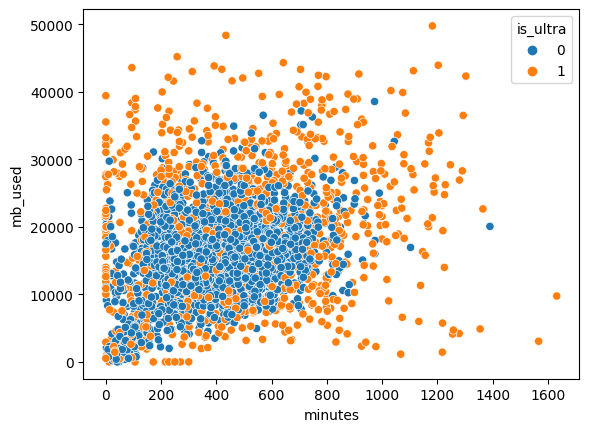

In [11]:
sns.scatterplot(data=df, x='minutes',y='mb_used', hue=target)
plt.show()

**Подитог к графику:** Как можно заметить основная часть тарифов "Смарт" = 0 находится в центральной зоне , в интервале от 0 до 700 минут по затраченному времени разговоров по телефону. 

А по затратам интернет трафика основная часть людей использующих тариф "Смарт" находится в диапазоне от 0 до 28 000 мб.

За пределами скопления пользователей использующих тариф "Смарт" находятся пользователи использующие тариф "Ультра". 

По данному графику можно сделать 2 главных вывода:
- Клиентам использующих тариф "Ультра" и находящиеся в диапазонах тарифа "Смарт" больше подойдет тариф "Смарт"
- Клиентам использующих тариф "Смарт" находящихся за пределами основной части скопления синих кружков, подойдет больше тариф "Ультра"


## Исследуйте модели

•	**Дерево решений**



In [12]:
%%time # 1-ый вариант подсчета кода
from tqdm import tqdm # 2-ой вариант подсчета выполнения кода

best_model = None
best_result = 0
best_depth = 0
for depth in tqdm(range(1, 6)):
    model = DecisionTreeClassifier(random_state=12345, max_depth= depth) 
    model.fit(features_train, target_train) # обучите модель
    predictions_valid = model.predict(features_valid) # получите предсказания модели
    result = accuracy_score(target_valid, predictions_valid)
    #result = model.score(features_valid, target_valid ) можно и так и без двух строк выше
    if result > best_result:
            best_model = model # сохраните наилучшую модель
            best_result = result #  сохраните наилучшее значение метрики accuracy на валидационных данных
            best_depth = depth
print("Accuracy наилучшей модели на валидационной выборке:", best_result)
print("Глубина наилучшей модели на валидационной выборке:", best_depth)      





UsageError: Can't use statement directly after '%%time'!


**Вывод**
Accuracy лучшей модели из десяти равно  0.7884914463452566, с гиперпараметром max_depth равным - 4.

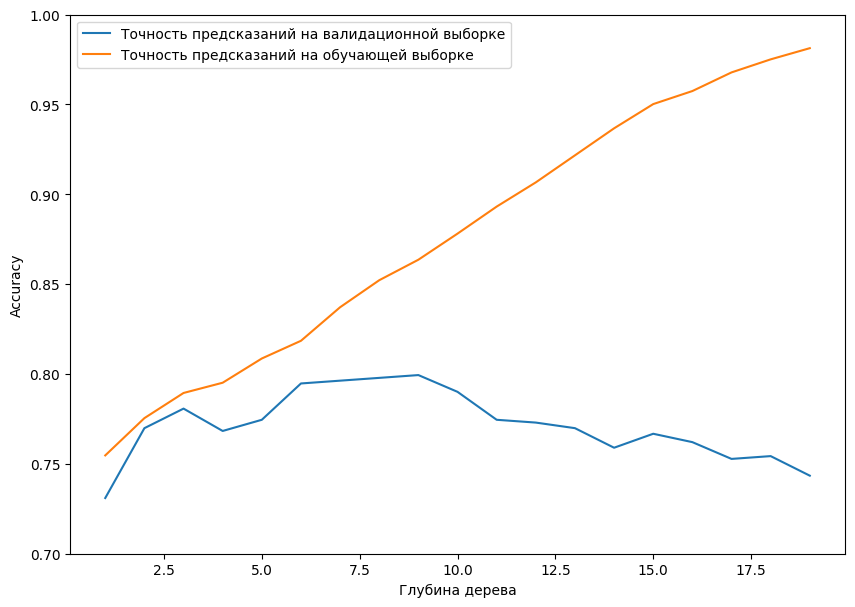

In [13]:
# код ревьюера

import numpy as np
from sklearn.metrics import accuracy_score

acc_valid = [] # сюда записывается accuracy по валидационной
acc_train = [] # сюда записывается accuracy по обучающей

depth_ = 20

for depth in range(1, depth_):
    model_tree = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_tree.fit(features_train, target_train) # здесь провел обучение на обучающей (не тестовой)
    
    predictions_valid = model_tree.predict(features_valid)# здесь загрузил данные по валидационной
    predictions_train = model_tree.predict(features_train)# здесь загрузил данные по обучающей
    
#     собираем результаты в списки
    acc_valid.append(accuracy_score(target_valid, predictions_valid))   
    acc_train.append(accuracy_score(target_train, predictions_train))   
    
    
fig, ax = plt.subplots(figsize = (10, 7))
fig.suptitle('') # здесь можно указать названия графика сверху

# строим по спискам графики
ax.plot(np.arange(1, depth_), acc_valid )
ax.plot(np.arange(1, depth_), acc_train)

ax.set_xlabel('Глубина дерева')
ax.set_ylabel('Accuracy')

ax.legend(['Точность предсказаний на валидационной выборке', 'Точность предсказаний на обучающей выборке'])

plt.ylim(0.7, 1);  

•	**Случайный лес**

In [14]:
%%time
best_model_1 = None
best_result_1 = 0
best_est_1 = 0
best_depth_1 = 0
for est in range(10, 51, 10): # кол-во деревьев с шагом 10
    for depth in range (1, 11): # количество вопросов (глубина)
        model_1 = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth = depth) # обучите модель с заданным количеством деревьев
        model_1.fit(features_train,target_train ) # обучите модель на тренировочной выборке
        predictions_valid_1 = model_1.predict(features_valid)
        result_1 = accuracy_score(target_valid, predictions_valid_1) # посчитайте качество модели на валидационной выборке
        if result_1 > best_result_1:
            best_model_1 = model_1 # сохраните наилучшую модель
            best_result_1 = result_1 #  сохраните наилучшее значение метрики accuracy на валидационных данных
            best_depth_1 = depth
            best_est_1 = est
print("Accuracy наилучшей модели на валидационной выборке:", best_result_1)
print("Глубина наилучшей модели на валидационной выборке:", best_depth_1)
print("Количество деревье наилучшей модели на валидационной выборке:", best_est_1)


Accuracy наилучшей модели на валидационной выборке: 0.8304821150855366
Глубина наилучшей модели на валидационной выборке: 8
Количество деревье наилучшей модели на валидационной выборке: 50
Wall time: 3.35 s


- **Логистическая регрессия**

In [15]:
from sklearn.linear_model import LogisticRegression 
model_2 = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000)     
 
model_2.fit(features_train,target_train)

predictions_valid_2 = model_2.predict(features_valid)
result_2 = accuracy_score(predictions_valid_2, target_valid)
print('Accuracy LogisticRegression:', result_2)


Accuracy LogisticRegression: 0.7216174183514774


## Вывод
1) Наилучший результат Accuracy у модели случайный лес - RandomForestClassifier. Accuracy равен 0.7993779160186625.

2) Следующий результат у решающего дерева - DecisionTreeClassifier. Accuracy у данной модели равен 0.7884914463452566

3) И самое слабое качество у логистической регрессии. Accuracy LogisticRegression: 0.7076205287713841

## Проверьте модель на тестовой выборке

***Из трех моделей лучший результат показала модель - RandomForestClassifier. На ней и проверим тестовую выборку:***

In [16]:
best_model_1 = None
best_result_1 = 0
best_est_1 = 0
best_depth_1 = 0
feature_all = pd.concat([features_train, features_valid], ignore_index=True) # объединили и индексы занова пронумировали
target_all = pd.concat([target_train, target_valid], ignore_index=True) # объединили по таргетам
model_test = RandomForestClassifier(random_state=12345, n_estimators=20, max_depth = 8)
model_test.fit(feature_all,target_all)
result_3 = model_test.score( features_test, target_test)


print("Accuracy наилучшей модели на тестовой выборке:", result_3)


Accuracy наилучшей модели на тестовой выборке: 0.8273716951788491


### Вывод: 
Accuracy у модели случайного леса - RandomForestClassifier на тестовой выборке равна 0.80248833592535

## (бонус) Проверьте модели на адекватность

Для проверки используем модель DummyClassifier.

In [ ]:
model_ = DummyClassifier(strategy='most_frequent', random_state=1)
model_.fit(features_train, target_train)
result_4 = model_.score(features_valid, target_valid)
print('Accuracy DummyClassifier:', result_4)

print('Accuracy RandomForestClassifier:', result_3)

**Вывод:**
Accuracy модели DummyClassifier ниже, чем у модели RandomForestClassifier - модель адекватна и эффективна.